## Imports


In [1]:
import os
import cv2
import torch
import random

import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from torch import nn
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from pthflops import count_ops
from torchsummary import summary
from prettytable import PrettyTable

from torchvision.utils import make_grid
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from albumentations.augmentations.geometric.rotate import Rotate

print(torch.__version__)


## Visualization


### Channels


The folder contains 8400 images.


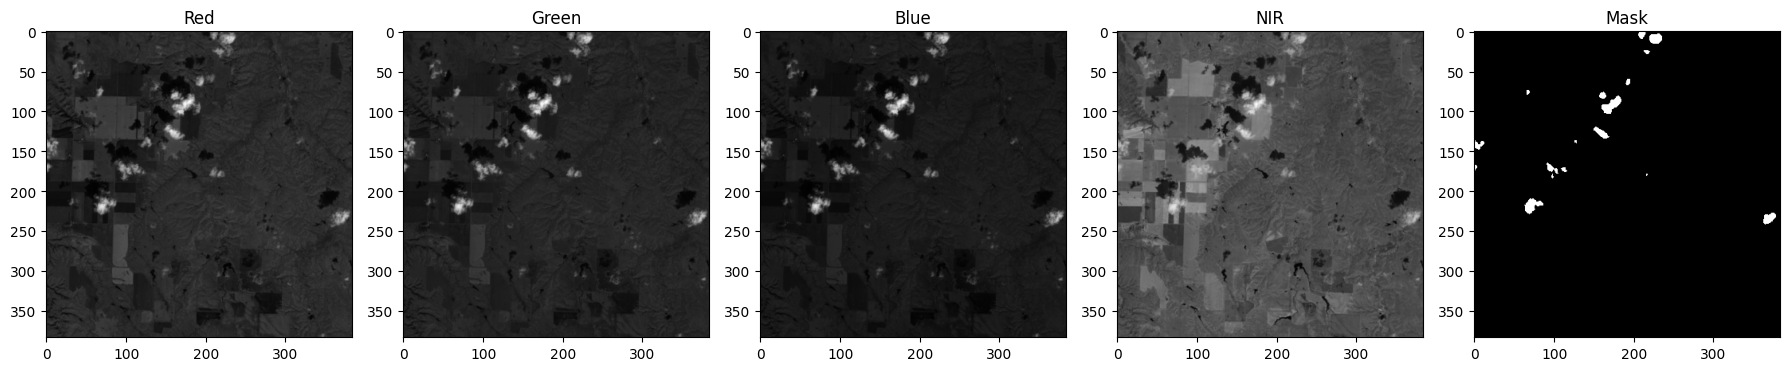

[(147456, 255)]


In [2]:
ROOT_DIR  = r"C:\Users\hdmqu\Documents\GitHub\Improved_C-FCN"

RED_PATH  = r"C:/Users/hdmqu/Downloads/38-Cloud_training/train_red/"
CKPT_PATH = os.path.join(ROOT_DIR, "models/checkpoints/checkpoint.pt")
FI_PATH   = os.path.join(ROOT_DIR, "filtered_images.txt")

lst = os.listdir(RED_PATH)
red_images = [os.path.join(RED_PATH, i) for i in lst]

print(f"The folder contains {len(red_images)} images.")

image_path = random.choice(red_images)

red_image   = Image.open(image_path)
green_image = Image.open(image_path.replace("red", "green"))
blue_image  = Image.open(image_path.replace("red", "blue"))
nir_image   = Image.open(image_path.replace("red", "nir"))
gt_image    = Image.open(image_path.replace("red", "gt"))

fig, axs = plt.subplots(1, 5, figsize=(18, 18))
axs[0].imshow(red_image,   cmap="gray")
axs[0].set_title("Red")
axs[1].imshow(green_image, cmap="gray")
axs[1].set_title("Green")
axs[2].imshow(blue_image,  cmap="gray")
axs[2].set_title("Blue")
axs[3].imshow(nir_image,   cmap="gray")
axs[3].set_title("NIR")
axs[4].imshow(gt_image,    cmap="gray")
axs[4].set_title("Mask")

fig.tight_layout()
plt.show()

color_list = Image.Image.getcolors(red_image.convert('L'))
print(color_list)

### Array


In [3]:
mask = np.array(gt_image)
print(f"Mask shape {mask.shape}")
print(f"Min = {mask.min()} , Max = {mask.max()}")
print(mask)


Mask shape (384, 384)
Min = 0 , Max = 255
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Dataloading


### Data Split


In [4]:
if os.path.exists(FI_PATH):
    with open(FI_PATH, 'r') as f:
        x = f.read()
        filtered_images = x.split("\n")
else:  
    filtered_images = []

    for file in red_images:
        img = Image.open(file).convert('L')
        color_list = Image.Image.getcolors(img)

        if color_list[0][1] == 0 and color_list[0][0] < 73728: # 384*384/2
            filtered_images.append(file)
        if color_list[0][1] == 255:
            filtered_images.append(file)
            
    with open('./filtered_images.txt','w') as f:
        for x in filtered_images:
            f.write(x + "\n")

In [6]:
print("No. original images:     ", len(red_images))
print("No. images after filter: ", len(filtered_images))
print("Percentage to original images: {int(len(filtered_images) / len(red_images) * 100)} %")

8400
4821


In [5]:
train_to_val = 0.85

images = np.split(filtered_images, [int(
    len(filtered_images) * train_to_val), len(filtered_images)])
train_images = images[0]
valid_images = images[1]

print(f"Train images: {len(images[0])}")
print(f"Valid images: {len(images[1])}")
print(f"Total images: {len(images[0]) + len(images[1])}")


Train images: 4097
Valid images: 724
Total images: 4821


### Dataset


In [8]:
class CloudDataset(Dataset):
    def __init__(self, file_list):
        super().__init__()
        self.files = [self.combine_files(f)
                      for f in file_list if not os.path.isdir(f)]

        # Augmentation pipeline
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            Rotate(limit=5, p=0.9),
            ToTensorV2(),
        ])

    def combine_files(self, r_file: Path):
        files = {
            "red":   r_file,
            "green": r_file.replace("red", "green"),
            "blue":  r_file.replace("red", "blue"),
            "nir":   r_file.replace("red", "nir"),
            "gt":    r_file.replace("red", "gt")
        }
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx, include_nir=False):
        # Image
        raw_rgb = np.stack([
            cv2.imread(self.files[idx]["red"])[:, :, 0],
            cv2.imread(self.files[idx]["green"])[:, :, 0],
            cv2.imread(self.files[idx]["blue"])[:, :, 0],
        ], axis=2)

        if include_nir:
            nir = np.expand_dims(cv2.imread(self.files[idx]["nir"]), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
            
        # Normalize
        raw_rgb = raw_rgb / np.iinfo(raw_rgb.dtype).max

        # Mask
        raw_mask = cv2.imread(self.files[idx]["gt"])[:, :, 0]
        raw_mask = np.where(raw_mask == 255, 1, 0)

        # Data augmentation
        result = self.transform(image=raw_rgb, mask=raw_mask)
        image, mask = result["image"].float(), result["mask"].long()

        return image, mask

    def __repr__(self):
        return f"Dataset class with {self.__len__()} files"


train_dataset = CloudDataset(images[0])
valid_dataset = CloudDataset(images[1])

print(train_dataset)
print(valid_dataset)

Dataset class with 4097 files
Dataset class with 724 files


Image: torch.Size([3, 384, 384])
Mask:  torch.Size([384, 384])


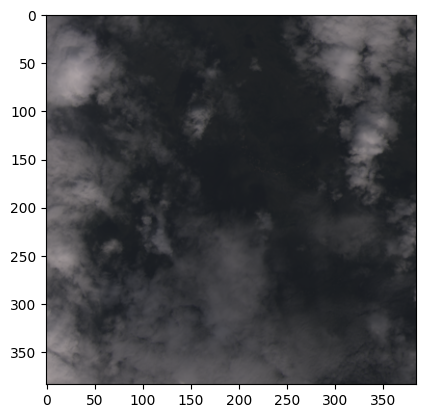

In [7]:
# single input example
x, y = train_dataset[0]
print(f"Image: {x.shape}")
print(f"Mask:  {y.shape}")

### Dataloader


In [8]:
# Constants
BATCH_SIZE = 16
NUM_WORKER = 8
NUM_EPOCHS = 150
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {DEVICE} device.")


Using cpu device.


In [1]:
def my_collate(batch):
    batch = list(filter(lambda x: torch.sum(x[0]).item() != 0, batch))
    if len(batch) == 0:
        print("DOOOOO")
        return (default_collate(torch.zeros(BATCH_SIZE, 3, 384, 384),
                                torch.zeros(BATCH_SIZE,    384, 384)))
    return default_collate(batch)


In [12]:
torch.manual_seed(42)

train_loader = DataLoader(train_dataset, BATCH_SIZE,
                          shuffle=True, num_workers=NUM_WORKER)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE,
                          shuffle=True, num_workers=NUM_WORKER)


In [11]:
# View batch
x, _ = next(iter((train_loader)))
_, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(x, nrow=4).permute(1, 2, 0))


## Training


### Model


In [15]:
class C_FCN(nn.Module):
    def __init__(self, in_channels, out_channels, proto: str, skip_connections=False):
        super().__init__()

        self.skip_connections = skip_connections

        self.conv1 = self.contract_block(in_channels, 5)
        self.conv2 = self.contract_block(5, 2)

        if proto == "BI":
            self.out1 = self.output_block(2, out_channels)
            self.out2 = nn.UpsamplingBilinear2d(scale_factor=4)

        elif proto == "TC":
            self.out1 = self.output_block(2, 2)
            self.out2 = nn.ConvTranspose2d(
                2, out_channels, stride=4, kernel_size=4, padding=0)

        elif proto == "DT":
            self.out1 = self.output_block(2, 2)
            self.out2 = nn.Sequential(
                nn.ConvTranspose2d(2, 2, stride=4, kernel_size=4, padding=0),
                nn.ConvTranspose2d(2, out_channels, stride=4, kernel_size=4, padding=0))

        else:
            raise ValueError()

        self.skip_con = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(4, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)

        out = self.out1(out)
        out = self.out2(out)

        # Skipped connections
        if self.skip_connections:
            out = self.skip_con(torch.cat((out, x), dim=1))

        return out

    def contract_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        contract = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        return contract

    def output_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        out = nn.Sequential(
            nn.Conv2d(in_channels, 2, kernel_size=kernel_size,
                      padding=padding),
            nn.ReLU(inplace=True),
            nn.Conv2d(2, out_channels, kernel_size=1, padding=0),
            nn.Sigmoid()
        )
        return out


In [16]:
model = C_FCN(3, 1, "BI", False)
model.to(DEVICE)

criterion = nn.BCELoss()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


def accuracy(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean().item()


In [17]:
class EarlyStopping:

    def __init__(self, patience=7, verbose=False, delta=0, path=CKPT_PATH, trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [ ]:
summary(model, (3, 384, 384))

In [18]:
# For C-UNet and C-FCN

train_losses = []
valid_losses = []
valid_accuracies = []

early_stopping = EarlyStopping(verbose=True)

for epoch in range(1, NUM_EPOCHS + 1):
    # TRAIN
    model.train()

    # Epoch metrics
    train_loss = []
    valid_loss = []
    valid_acc = []

    # Load training batch
    for images, targets in tqdm(train_loader):
        # Send to device
        images = images.to(DEVICE)
        targets = targets.to(DEVICE)

        # Loss
        predictions = model(images)
        loss = criterion(predictions, targets)
        train_loss.append(loss.item())

        # Reset gradients
        optimizer.zero_grad()

        # Back Propagation
        loss.backward()

        # Update the parameters
        optimizer.step()

    # EVALUATION
    model.eval()

    # Load validation batch
    for images, targets in tqdm(valid_loader):
        with torch.no_grad():
            # Send to device
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)

            # Loss
            predictions = model(images)
            loss = criterion(predictions, targets)
            valid_loss.append(loss.item())

            # Accuracy
            valid_acc.append(accuracy(predictions, targets))

            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print("Early stop")
                model.load_state_dict(torch.load(CKPT_PATH))
                break

    # Log
    train_losses.append(np.mean(train_loss))
    valid_losses.append(np.mean(valid_loss))
    valid_accuracies.append(np.mean(valid_acc))
    print(f"Epoch [{epoch + 1}], train_loss: {train_losses[-1]}, val_loss: {valid_losses[-1]}, val_acc: {valid_accuracies[-1]}")


  0%|          | 0/129 [00:00<?, ?it/s]

In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

# visualize the loss as the network trained
fig = plt.figure(figsize=(10, 8))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(valid_losses)+1), valid_losses, label="Validation Loss")

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss)) + 1
plt.axvline(minposs, linestyle="--", color='r',
            label="Early Stopping Checkpoint")

plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0, 0.5)  # consistent scale
plt.xlim(0, len(train_loss)+1)  # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig("loss_plot.png", bbox_inches="tight")


### To ONNX


In [ ]:
dummy_input = torch.randn(1, 3, 384, 384)
torch.onnx.export(model, dummy_input, "./")


### Evaluate Model


In [ ]:
def get_mask(pred):
    pred = pred.squeeze()
    mask_pred = np.zeros([384, 384, 3])

    mask_pred[:, :, 0] = pred * 255
    mask_pred[:, :, 1] = pred * 255
    mask_pred[:, :, 2] = pred * 255

    return mask_pred


In [ ]:
images = [
    test_dataset[416],
    test_dataset[156],
    test_dataset[756],
    test_dataset[23]
]

fig, axs = plt.subplots(3, len(images), figsize=(18, 10))

i = 0
for image in images:
    # Retrieve and format results
    display_im = image[0].permute(1, 2, 0).cpu().detach().numpy()
    # Add ["out"] before .cpu() for DeepLabV3 and FCN
    pred = model(image[0].unsqueeze(0)).cpu().detach().numpy()
    pred = get_mask(pred)
    pred = pred.squeeze()

    mask = image[1]

    # Display
    axs[0][i].imshow(display_im)
    axs[0][i].set_title("Image")
    axs[1][i].imshow(mask)
    axs[1][i].set_title("Ground Truth")
    axs[2][i].imshow(pred)
    axs[2][i].set_title("Predicted Mask")

    # Increment count
    i += 1

fig.tight_layout()
plt.show()


### Analysis


#### Number of parameters


In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


In [ ]:
count_parameters(model)


#### Number of FLOPS


In [ ]:
# Sample input
inp = torch.rand(1, 4, 384, 384)

# Count the number of FLOPs
count_ops(model, inp)


## Results


### Validation Accuracy


In [ ]:
plt.plot(valid_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy by epoch")


### Losses


In [ ]:
plt.plot(train_losses, label="training")
plt.plot(valid_losses, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Losses by epoch")
